<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**The first step is to establish that something is possible; then probability will occur - [Elon Musk](https://en.wikipedia.org/wiki/Elon_Musk)**

# Chapter 13 Survival Analysis

**Survival analysis** is a way to describe how long things last. It is often used to study human lifetimes, but it also applies to “survival” of mechanical and electronic components, or more generally to intervals in time before an event.

If someone you know has been diagnosed with a life-threatening disease, you might have seen a “5-year survival rate,” which is the probability of surviving five years after diagnosis. That estimate and related statistics are the result of survival analysis.

## Survival curves

The fundamental concept in survival analysis is the survival curve, S(t), which is a function that maps from a duration, t, to the probability of surviving longer than t. If you know the distribution of durations, or “lifetimes”, finding the survival curve is easy; it’s just the complement of the CDF:<br>
![alt text](Resources/Think_Stats/notebookpics/survival_formula.png "Title")

where CDF (t) is the probability of a lifetime less than or equal to t.

For example, in the NSFG dataset, we know the duration of 11189 complete
pregnancies. We can read this data and compute the CDF:

In [5]:
from Resources.Think_Stats.Thinkstats2 import nsfg
from Resources.Think_Stats.Thinkstats2  import thinkstats2
from Resources.Think_Stats.Thinkstats2  import thinkplot
from Resources.Think_Stats.Thinkstats2  import survival
from Resources.Think_Stats.Thinkstats2  import chap01soln

In [2]:
preg = nsfg.ReadFemPreg(dct_file='Resources/Think_Stats/Thinkstats2/2002FemPreg.dct',
                        dat_file='Resources/Think_Stats/Thinkstats2/2002FemPreg.dat.gz')

complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

The outcome codes 1, 3, 4 indicate live birth, stillbirth, and miscarriage. For this analysis I am excluding induced abortions, ectopic pregnancies, and pregnancies that were in progress when the respondent was interviewed.

The DataFrame method query takes a boolean expression and evaluates it for each row, selecting the rows that yield True.

Figure 13.1 (top) shows the CDF of pregnancy length and its complement, the survival curve. To represent the survival curve, I define an object that wraps a Cdf and adapts the interface:

In [8]:
import inspect
lines = inspect.getsource(survival.SurvivalFunction)
print(lines)

class SurvivalFunction(object):
    """Represents a survival function."""

    def __init__(self, ts, ss, label=''):
        self.ts = ts
        self.ss = ss
        self.label = label

    def __len__(self):
        return len(self.ts)

    def __getitem__(self, t):
        return self.Prob(t)

    def Prob(self, t):
        """Returns S(t), the probability that corresponds to value t.
        t: time
        returns: float probability
        """
        return np.interp(t, self.ts, self.ss, left=1.0)

    def Probs(self, ts):
        """Gets probabilities for a sequence of values."""
        return np.interp(ts, self.ts, self.ss, left=1.0)

    def Items(self):
        """Sorted sequence of (t, s) pairs."""
        return zip(self.ts, self.ss)

    def Render(self):
        """Generates a sequence of points suitable for plotting.
        returns: tuple of (sorted times, survival function)
        """
        return self.ts, self.ss

    def MakeHazardFunction(self, label=''):
     

In [9]:
class SurvivalFunction(object):
    def __init__(self, cdf, label=''):
        self.cdf = cdf
        self.label = label or cdf.label
    
    def __getitem__(self, t):
        return self.Prob(t)
    
    def Prob(self, t):
        return 1 - self.cdf.Prob(t)

    @property
    def ts(self):
        return self.cdf.xs

    @property
    def ss(self):
        return 1 - self.cdf.ps

SurvivalFunction provides two properties: ts, which is the sequence of lifetimes, and ss, which is the survival curve. In Python, a “property” is a method that can be invoked as if it were a variable.

We can instantiate a `SurvivalFunction` by passing the CDF of lifetimes:

In [10]:
sf = SurvivalFunction(cdf)

In [11]:
from Thinkstats2 import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [12]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

For example, sf[13] is the fraction of pregnancies that proceed past the first trimester:

In [13]:
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


About 86% of pregnancies proceed past the first trimester; about 14% do not.

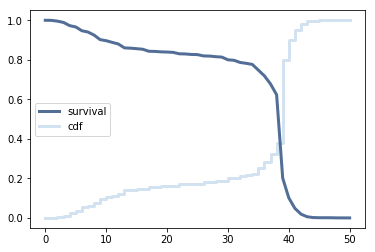

In [14]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

This chart shows the result. The curve is nearly flat between 13 and 26 weeks, which shows that few pregnancies end in the second trimester. And the curve is steepest around 39 weeks, which is the most common pregnancy length.

## Hazard function

From the survival curve we can derive the hazard function; for pregnancy lengths, the hazard function maps from a time, t, to the fraction of pregnancies that continue until t and then end at t. To be more precise:<br>
![alt text](Resources/Think_Stats/notebookpics/hazard.png "Title")

The numerator is the fraction of lifetimes that end at t, which is also PMF(t).

`SurvivalFunction` provides `MakeHazard`, which calculates the hazard function, try to code yourself the hazard function from your survival function:

In [15]:
# Code it here

Compare your result with the one implemented in the code above.

In [16]:
hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.6767068273092369


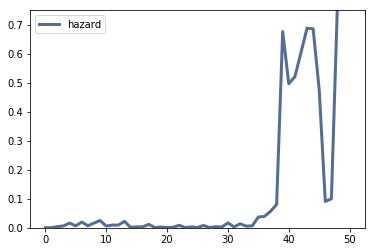

In [17]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

The plot shows the hazard function for pregnancy lengths. For times after week 42, the hazard function is erratic because it is based on a small number of cases. Other than that the shape of the curve is as expected: it is highest around 39 weeks, and a little higher in the first trimester than in the second.

The hazard function is useful in its own right, but it is also an important tool for estimating survival curves, as we’ll see in the next section.

## Inferring survival curves 

If someone gives you the CDF of lifetimes, it is easy to compute the survival and hazard functions. But in many real-world scenarios, we can’t measure the distribution of lifetimes directly. We have to infer it.

For example, suppose you are following a group of patients to see how long they survive after diagnosis. Not all patients are diagnosed on the same day, so at any point in time, some patients have survived longer than others. If
some patients have died, we know their survival times. For patients who are still alive, we don’t know survival times, but we have a lower bound.

If we wait until all patients are dead, we can compute the survival curve, but if we are evaluating the effectiveness of a new treatment, we can’t wait that long! We need a way to estimate survival curves using incomplete information.

As a more cheerful example, I will use NSFG data to quantify how long respondents “survive” until they get married for the first time. The range of respondents’ ages is 14 to 44 years, so the dataset provides a snapshot of
women at different stages in their lives.

For women who have been married, the dataset includes the date of their first marriage and their age at the time. For women who have not been married, we know their age when interviewed, but have no way of knowing when or if
they will get married.

Since we know the age at first marriage for some women, it might be tempting to exclude the rest and compute the CDF of the known data. That is a bad idea. The result would be doubly misleading: (1) older women would be overrepresented, because they are more likely to be married when interviewed, and (2) married women would be overrepresented! In fact, this analysis would lead to the conclusion that all women get married, which is obviously incorrect.

## Kaplan-Meier estimation

In this example it is not only desirable but necessary to include observations of unmarried women, which brings us to one of the central algorithms in survival analysis, **Kaplan-Meier estimation**.

The general idea is that we can use the data to estimate the hazard function, then convert the hazard function to a survival curve. To estimate the hazard function, we consider, for each age, (1) the number of women who got married
at that age and (2) the number of women “at risk” of getting married, which includes all women who were not married at an earlier age.

Here’s the code:

We'll use the NSFG respondent file to estimate the hazard function and survival function for age at first marriage.

In [9]:
resp6 = nsfg.ReadFemResp()

We have to clean up a few variables.

In [10]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

And the extract the age at first marriage for people who are married, and the age at time of interview for people who are not.

In [11]:
complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

The following function uses Kaplan-Meier to estimate the hazard function.

In [ ]:
from collections import Counter

In [18]:
def EstimateHazardFunction(complete, ongoing, label=''):
    
    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)
    
    ts = list(hist_complete | hist_ongoing)
    ts.sort()
    
    at_risk = len(complete) + len(ongoing)
    lams = pandas.Series(index=ts)
    
    for t in ts:        
        ended = hist_complete[t]
        censored = hist_ongoing[t]
        
        lams[t] = ended / at_risk
        at_risk -= ended + censored
        
    return HazardFunction(lams, label=label)

`complete` is the set of complete observations; in this case, the ages when respondents got married. ongoing is the set of incomplete observations; that is, the ages of unmarried women when they were interviewed.

First, we precompute hist_complete, which is a Counter that maps from each age to the number of women married at that age, and hist_ongoing which maps from each age to the number of unmarried women interviewed at that age.

ts is the union of ages when respondents got married and ages when unmarried women were interviewed, sorted in increasing order.

at_risk keeps track of the number of respondents considered “at risk” at each age; initially, it is the total number of respondents.

The result is stored in a Pandas Series that maps from each age to the estimated hazard function at that age.

Each time through the loop, we consider one age, t, and compute the number of events that end at t (that is, the number of respondents married at that age) and the number of events censored at t (that is, the number of women
interviewed at t whose future marriage dates are censored). In this context, “censored” means that the data are unavailable because of the data collection process.

The estimated hazard function is the fraction of the cases at risk that end at t.

At the end of the loop, we subtract from at_risk the number of cases that ended or were censored at t.

## The marriage curve

To test this function, we have to do some data cleaning and transformation. The NSFG variables we need are:

- cmbirth: The respondent’s date of birth, known for all respondents.
- cmintvw: The date the respondent was interviewed, known for all respondents.
- cmmarrhx: The date the respondent was first married, if applicable and known.
- evrmarry: 1 if the respondent had been married prior to the date of interview, 0 otherwise.

The first three variables are encoded in “century-months”; that is, the integer number of months since December 1899. So century-month 1 is January 1900.

First, we read the respondent file:

In [7]:
resp = nsfg.ReadFemResp()

replace invalid values of cmmarrhx:

In [19]:
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

Then compute each respondent’s age when married and age when interviewed:

In [ ]:
resp6['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp6['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

Next we extract complete, which is the age at marriage for women who have been married, and ongoing, which is the age at interview for women who have not:

In [ ]:
complete = resp[resp.evrmarry==1].agemarry.dropna()
ongoing = resp[resp.evrmarry==0].age

Finally we compute the hazard function.

In [ ]:
hf = EstimateHazardFunction(complete, ongoing)

Plot the curve:

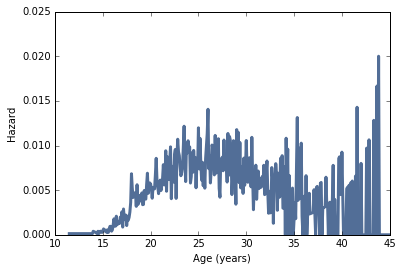

In [13]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

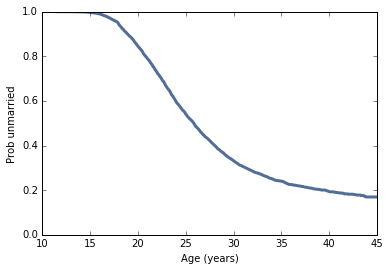

In [14]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1])

What do you interpret?

In [22]:
# Answer here

## Estimating the survival curve

Once we have the hazard function, we can estimate the survival curve. The chance of surviving past time t is the chance of surviving all times up through t, which is the cumulative product of the complementary hazard function:<br>

![alt text](Resources/Think_Stats/notebookpics/estimate_survival.png "Title")

Create a make survival function that given a hazard function creates a survival function:

In [15]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

Compare your implementation with the following:

In [ ]:
class HazardFunction:
    def MakeSurvival(self):
        ts = self.series.index
        ss = (1 - self.series).cumprod()
        cdf = thinkstats2.Cdf(ts, 1-ss)
        sf = SurvivalFunction(cdf)
        return sf

`ts` is the sequence of times where the hazard function is estimated. ss is the cumulative product of the complementary hazard function, so it is the survival curve.

Because of the way SurvivalFunction is implemented, we have to compute the complement of ss, make a Cdf, and then instantiate a SurvivalFunction object.

Compute and plot the survival curve of the previously calculated hazard function:

In [ ]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1])

A curve like this was the basis of a famous magazine article in 1986; Newsweek reported that a 40-year old unmarried woman was “more likely to be killed by a terrorist” than get married. These statistics were widely reported and became part of popular culture, but they were wrong then (because they were based on faulty analysis) and turned out to be even more wrong (because of cultural changes that were already in progress and continued). In 2006, Newsweek ran an another article admitting that they were wrong.

I encourage you to read more about this article, the statistics it was based on, and the reaction. It should remind you of the ethical obligation to perform statistical analysis with care, interpret the results with appropriate skepticism, and present them to the public accurately and honestly.

## Confidence intervals

Kaplan-Meier analysis yields a single estimate of the survival curve, but it is also important to quantify the uncertainty of the estimate. As usual, there are three possible sources of error: measurement error, sampling error, and modeling error.

In this example, measurement error is probably small. People generally know when they were born, whether they’ve been married, and when. And they can be expected to report this information accurately.

We can quantify sampling error by resampling. Here’s the code:

In [15]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [16]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

The following plot shows the survival function based on the raw data and a 90% CI based on resampling. Explain the 3 main steps taken to calculate the resampling.

In [ ]:
# Answer here

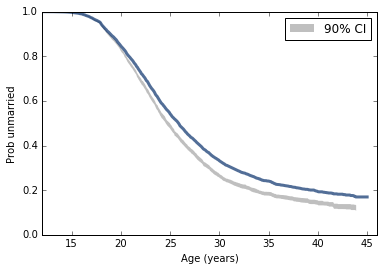

In [17]:
ResampleSurvival(resp6)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[12, 46],
                 ylim=[0, 1],
                 loc='upper right')

## Cohort effects

One of the challenges of survival analysis is that different parts of the estimated curve are based on different groups of respondents. The part of the curve at time t is based on respondents whose age was at least t when they
were interviewed. So the leftmost part of the curve includes data from all respondents, but the rightmost part includes only the oldest respondents.

If the relevant characteristics of the respondents are not changing over time, that’s fine, but in this case it seems likely that marriage patterns are different for women born in different generations. We can investigate this effect by grouping respondents according to their decade of birth. Groups like this, defined by date of birth or similar events, are called **cohorts**, and differences between the groups are called **cohort effects**.

To investigate cohort effects in the NSFG marriage data, I gathered the Cycle 6 data from 2002 used throughout this book; the Cycle 7 data from 2006–2010 used in Section 9.11; and the Cycle 5 data from 1995. In total these datasets include 30,769 respondents.

In [ ]:
resp5 = ReadFemResp1995()
resp6 = ReadFemResp2002()
resp7 = ReadFemResp2010()

resps = [resp5, resp6, resp7]

For each DataFrame, resp,use cmbirth to compute the decade of birth for each respondent:

In [20]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

To take into account the sampling weights, and also to show variability due to sampling error, resample the data, group respondents by decade, and plot survival curves:

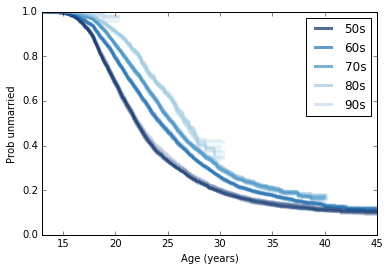

In [21]:
PlotResampledByDecade(resps)
thinkplot.Config(xlabel='Age (years)',
                   ylabel='Prob unmarried',
                   xlim=[13, 45],
                   ylim=[0, 1])

We can generate predictions by assuming that the hazard function of each generation will be the same as for the previous generation.

In [22]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

And here's what that looks like.

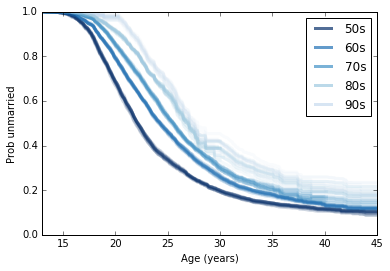

In [23]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

What conclusions can you raise from the data?

In [30]:
# Answer here

## Extrapolation

The survival curve for the 70s cohort ends at about age 38; for the 80s cohort it ends at age 28, and for the 90s cohort we hardly have any data at all. We can extrapolate these curves by “borrowing” data from the previous
cohort. HazardFunction provides a method, Extend, that copies the tail from another longer HazardFunction:

In [32]:
class HazardFunction:
    def Extend(self, other):
        last = self.series.index[-1]
        more = other.series[other.series.index > last]
        self.series = pandas.concat([self.series, more])

As we saw in Section 2, the HazardFunction contains a Series that maps from t to λ(t). Extend finds last, which is the last index in self.series, selects values from other that come later than last, and appends them onto self.series.

Now we can extend the HazardFunction for each cohort, using values from the predecessor:

In [ ]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

groups is a GroupBy object with respondents grouped by decade of birth. The first loop computes the HazardFunction for each group.

The second loop extends each HazardFunction with values from its predecessor, which might contain values from the previous group, and so on. Then it converts each HazardFunction to a SurvivalFunction and plots it.

In [ ]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

## Expected remaining lifetime

Given a survival curve, we can compute the expected remaining lifetime as a function of current age. For example, given the survival curve of pregnancy length from Section 1, we can compute the expected time until delivery.

The first step is to extract the PMF of lifetimes. SurvivalFunction provides a method that does that:

In [37]:
class SurvivalFunction:
    def MakePmf(self, filler=None):
        pmf = thinkstats2.Pmf()
        for val, prob in self.cdf.Items():
            pmf.Set(val, prob)
        
        cutoff = self.cdf.ps[-1]
        if filler is not None:
            pmf[filler] = 1-cutoff
        
        return pmf

Remember that the SurvivalFunction contains the Cdf of lifetimes. The loop copies the values and probabilities from the Cdf into a Pmf.

cutoff is the highest probability in the Cdf, which is 1 if the Cdf is complete, and otherwise less than 1. If the Cdf is incomplete, we plug in the provided value, filler, to cap it off.

The Cdf of pregnancy lengths is complete, so we don’t have to worry about this detail yet.

The next step is to compute the expected remaining lifetime, where “expected” means average. SurvivalFunction provides a method that does that, too:

In [39]:
class SurvivalFunction:
    def RemainingLifetime(self, filler=None, func=thinkstats2.Pmf.Mean):
        pmf = self.MakePmf(filler=filler)
        d = {}
        for t in sorted(pmf.Values())[:-1]:
            pmf[t] = 0
            pmf.Normalize()
            d[t] = func(pmf) - t
    
        return pandas.Series(d)

RemainingLifetime takes filler, which is passed along to MakePmf, and func which is the function used to summarize the distribution of remaining lifetimes.

pmf is the Pmf of lifetimes extracted from the SurvivalFunction. d is a dictionary that contains the results, a map from current age, t, to expected remaining lifetime.

The loop iterates through the values in the Pmf. For each value of t it computes the conditional distribution of lifetimes, given that the lifetime exceeds t. It does that by removing values from the Pmf one at a time and renormalizing the remaining values.

Then it uses func to summarize the conditional distribution. In this example the result is the mean pregnancy length, given that the length exceeds t. By subtracting t we get the mean remaining pregnancy length.

Plot the remaining lifetime graph of both pregnancy and marriage data:

In [ ]:
preg = nsfg.ReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))

What do you interpret from it:

In [40]:
# Answer here

We are plotting remaining pregnancy length as a function of the current duration. For example, during Week 0, the expected remaining duration is about 34 weeks. That’s less than full term (39 weeks) because terminations of pregnancy in the first trimester bring the average down.

The curve drops slowly during the first trimester. After 13 weeks, the expected remaining lifetime has dropped by only 9 weeks, to 25. After that the curve drops faster, by about a week per week.

Between Week 37 and 42, the curve levels off between 1 and 2 weeks. At any time during this period, the expected remaining lifetime is the same; with each week that passes, the destination gets no closer. Processes with this
property are called **memoryless** because the past has no effect on the predictions. This behavior is the mathematical basis of the infuriating mantra of obstetrics nurses: “any day now.”

Figure 13.6 (right) shows the median remaining time until first marriage, as a function of age. For an 11 year-old girl, the median time until first marriage is about 14 years. The curve decreases until age 22 when the median remaining time is about 7 years. After that it increases again: by age 30 it is back where it started, at 14 years.

Based on this data, young women have decreasing remaining ”lifetimes”. Mechanical components with this property are called **NBUE** for ”new better than used in expectation,” meaning that a new part is expected to last longer.

Women older than 22 have increasing remaining time until first marriage. Components with this property are called **UBNE** for ”used better than new in expectation.” That is, the older the part, the longer it is expected to last.
Newborns and cancer patients are also UBNE; their life expectancy increases the longer they live.

For this example I computed median, rather than mean, because the Cdf is incomplete; the survival curve projects that about 20% of respondents will not marry before age 44. The age of first marriage for these women is unknown, and might be non-existent, so we can’t compute a mean.
    
I deal with these unknown values by replacing them with np.inf, a special value that represents infinity. That makes the mean infinity for all ages, but the median is well-defined as long as more than 50% of the remaining
lifetimes are finite, which is true until age 30. After that it is hard to define a meaningful expected remaining lifetime.

In [ ]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
func = lambda pmf: pmf.Percentile(50)
rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
thinkplot.Plot(rem_life2)

sf1 is the survival curve for pregnancy length; in this case we can use the default values for RemainingLifetime.

sf2 is the survival curve for age at first marriage; func is a function that takes a Pmf and computes its median (50th percentile).